In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [33]:
# import and clean the data

# chrome data
df_chrome = pd.read_csv("CB_chrome_cleaned.csv")
df_chrome = df_chrome.rename(columns={"visit_date" : "date", "visit_time": "time"})
df_chrome["date"] = pd.to_datetime(df_chrome["date"])
df_chrome = df_chrome.drop("Unnamed: 0", axis=1)

def get_first_and_last_visits(df):
    # find first and last visited websites per date
    first_visits = df.loc[df.groupby("date")["time"].idxmin()]
    last_visits = df.loc[df.groupby("date")["time"].idxmax()]

    # select relevant columns
    first_visits = first_visits[["date", "time", "url", "title"]].rename(columns={
        "time": "visit_time_first",
        "url": "url_first",
        "title": "title_first"
    })
    
    last_visits = last_visits[["date", "time", "url", "title"]].rename(columns={
        "time": "visit_time_last",
        "url": "url_last",
        "title": "title_last"
    })

    # merge both DataFrames on visit_date to get one row per date
    visit_summary = pd.merge(first_visits, last_visits, on="date")
    return visit_summary

df_chrome = get_first_and_last_visits(df_chrome)

# sleep data
df_sleep = pd.read_csv("cheryl_sleep_data.csv")
df_sleep = df_sleep.drop("Unnamed: 0", axis=1)
df_sleep = df_sleep.rename(columns={"Date": "date"})
df_sleep["date"] = pd.to_datetime(df_sleep["date"])
df_sleep["sleep_start"] = pd.to_datetime(df_sleep["sleep_start"])
df_sleep["sleep_end"] = pd.to_datetime(df_sleep["sleep_end"])
df_sleep["sleep_start_date"] = df_sleep["sleep_start"].dt.date
df_sleep["sleep_start_time"] = df_sleep["sleep_start"].dt.strftime("%H:%M:%S")
df_sleep["sleep_end date"] = df_sleep["sleep_end"].dt.date
df_sleep["sleep_end_time"] = df_sleep["sleep_end"].dt.strftime("%H:%M:%S")
df_sleep = df_sleep.drop(columns=["sleep_start", "sleep_end"])
df_sleep["date"] = df_sleep["sleep_start_date"]
df_sleep["date"] = pd.to_datetime(df_sleep["sleep_start_date"]) # made the date the sleep start date so you can compare visit_time_last with sleep start time, can compare sleep end time with visit_time_first of the next date

# merge the two dataframes
df = pd.merge(df_chrome, df_sleep, on="date", how="left")

# filter for time between jan 1 to feb 17
start_date = "2025-01-01"
end_date = "2025-02-17"
df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

df.head()

,date,visit_time_first,url_first,title_first,visit_time_last,url_last,title_last,total_sleep_hours,sleep_start_date,sleep_start_time,sleep_end date,sleep_end_time
34,2025-01-01,02:05:20,https://www.google.com/search?q=dsw&rlz=1C1ONG...,dsw - Google Search,22:56:56,https://www.amazon.com/s/ref=nb_sb_noss_2?url=...,Amazon.com : daisque,8.258333,2025-01-01,02:04:45,2025-01-01,10:30:15
35,2025-01-02,01:46:11,https://www.when2meet.com/?28134141-GcoK8,Club Figure Skating Spring 2024 Off Ice - When...,02:52:13,https://www.amazon.com/s?crid=1WQFLCYQMS1FY&i=...,Amazon.com : rice mask,11.283333,2025-01-02,01:25:02,2025-01-02,16:03:02
36,2025-01-03,01:56:00,https://www.amazon.com/s?crid=2ZM9BIE3J8XA8&i=...,Amazon.com : canmake,02:14:16,https://www.popflexactive.com/collections/perf...,Perfect Plane Pants - Black – POPFLEX®,7.325000,2025-01-03,02:04:16,2025-01-03,09:45:16
37,2025-01-04,00:58:56,https://mandrillapp.com/track/click/30837889/b...,My Team Shop,02:50:25,https://bsnteamsports.com/shop/2rkrRzKBQS/myte...,My Team Shop,7.983333,2025-01-04,02:30:17,2025-01-04,16:18:02
38,2025-01-05,00:11:47,https://www.netflix.com/browse,Home - Netflix,23:22:58,https://discussions.apple.com/thread/254776692,does an air tag interfere with credit car… - A...,5.775000,2025-01-05,02:20:19,2025-01-05,10:14:49


In [38]:
# keyword analysis
# tally up keywords
keywords = ["uva", "canvas", "eqk9vb", "drive"]

tally_data = []
last_time_per_date = {}

for _, row in df.iterrows():
    row_tally = {"date": row["date"], "total_count": 0}
    
    # Count occurrences of each keyword
    for keyword in keywords:
        count = sum(row.astype(str).str.contains(keyword, case=False, na=False))
        row_tally[keyword] = count
        row_tally["total_count"] += count

    if row["date"] not in last_time_per_date:
        last_time_per_date[row["date"]] = row["visit_time"]
    else:
        if row["visit_time"] > last_time_per_date[row["date"]]:
            last_time_per_date[row["date"]] = row["visit_time"]
    
    tally_data.append(row_tally)

tally_df = pd.DataFrame(tally_data)
summary_df = tally_df.groupby("date", as_index=False).sum()
summary_df["last_time"] = summary_df["date"].map(last_time_per_date)

KeyError: 'visit_time'

In [34]:
# summary of information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 34 to 77
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               44 non-null     datetime64[ns]
 1   visit_time_first   44 non-null     object        
 2   url_first          44 non-null     object        
 3   title_first        43 non-null     object        
 4   visit_time_last    44 non-null     object        
 5   url_last           44 non-null     object        
 6   title_last         44 non-null     object        
 7   total_sleep_hours  39 non-null     float64       
 8   sleep_start_date   39 non-null     object        
 9   sleep_start_time   39 non-null     object        
 10  sleep_end date     39 non-null     object        
 11  sleep_end_time     39 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 4.5+ KB


In [35]:
# some statistics about the dataset
df.describe()

,date,total_sleep_hours
count,44,39.000000
mean,2025-01-23 13:05:27.272727296,7.482692
min,2025-01-01 00:00:00,4.525000
25%,2025-01-11 18:00:00,6.400000
50%,2025-01-23 12:00:00,7.575000
75%,2025-02-04 06:00:00,8.329167
max,2025-02-14 00:00:00,11.283333
std,NaN,1.368131


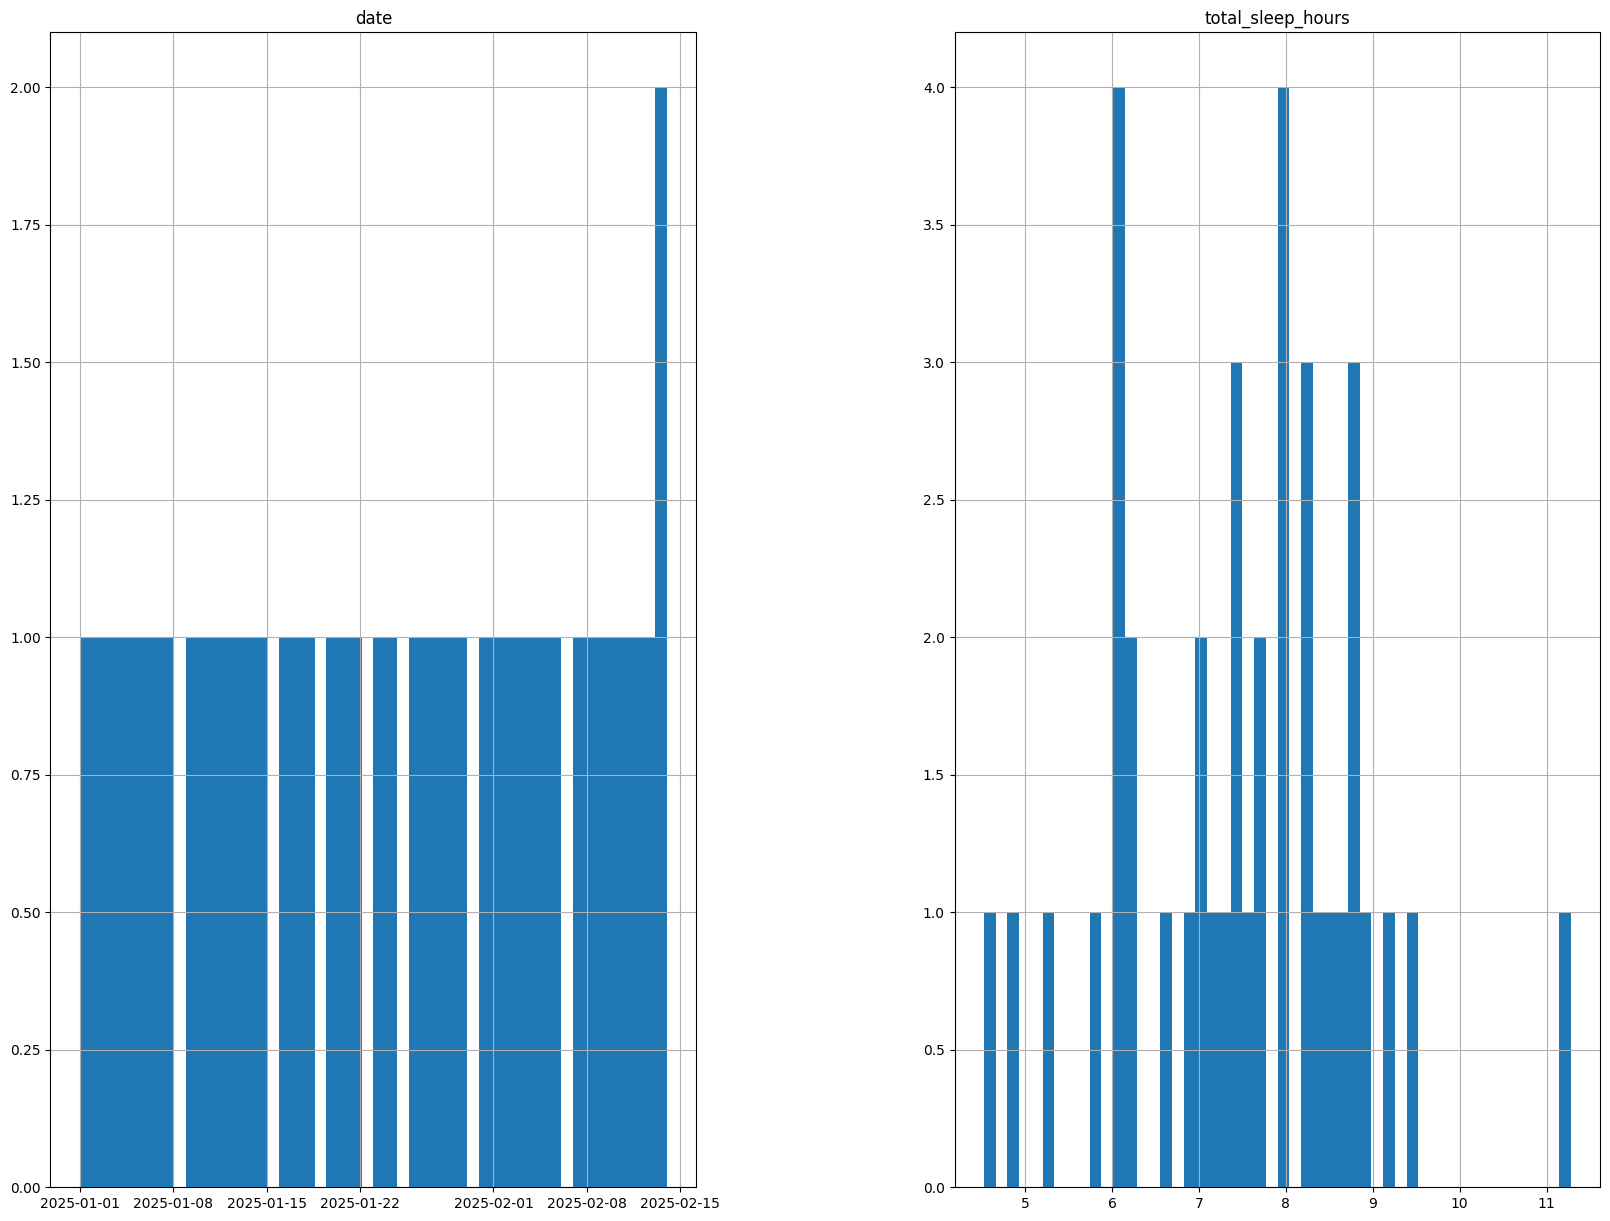

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
df.hist(bins=50, figsize=(20, 15))
plt.subplots_adjust(wspace=0.4,hspace=0.6)
plt.show()

In [23]:
df = pd.read_csv('elaine_data.csv')
df.head()

,Unnamed: 0.1,date,total_sleep_hours,sleep_start,sleep_end,youtube_visit_time_first,youtube_visit_time_last,total_videos_watched,chrome_visit_time_first,chrome_visit_time_last,Unnamed: 0,total_count,uva,canvas,zzb2rf,drive,last_time
0,0,2025-01-01,7.566667,2025-01-01 01:58:50-05:00,2025-01-01 10:00:20-05:00,1900-01-01 11:24:47.221,1900-01-01 17:20:12.713,6.0,1900-01-01 19:28:58.402504,1900-01-01 20:49:10.591911,312,0,0,0,0,0,20.816667
1,1,2025-01-02,6.608333,2025-01-02 02:10:26-05:00,2025-01-02 08:59:56-05:00,1900-01-01 10:42:48.218,1900-01-01 22:42:36.226,45.0,1900-01-01 20:57:04.877178,1900-01-01 21:02:22.430207,313,0,0,0,0,0,21.033333
2,2,2025-01-05,8.775000,2025-01-05 00:32:58-05:00,2025-01-05 09:33:28-05:00,1900-01-01 19:34:25.659,1900-01-01 22:56:39.120,39.0,1900-01-01 16:03:46.136767,1900-01-01 16:57:30.015037,316,0,0,0,0,0,16.950000
3,3,2025-01-06,7.733333,2025-01-06 00:39:27-05:00,2025-01-06 08:26:57-05:00,1900-01-01 14:20:29.624,1900-01-01 21:25:50.348,14.0,1900-01-01 12:58:09.802701,1900-01-01 15:28:02.495664,317,0,0,0,0,0,15.466667
4,4,2025-01-07,8.425000,2025-01-07 01:11:51-05:00,2025-01-07 09:47:21-05:00,1900-01-01 14:54:35.739,1900-01-01 21:44:19.344,26.0,1900-01-01 20:20:22.024937,1900-01-01 20:22:32.044121,318,20,2,0,0,18,20.366667


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              36 non-null     int64  
 1   date                      36 non-null     object 
 2   total_sleep_hours         36 non-null     float64
 3   sleep_start               36 non-null     object 
 4   sleep_end                 36 non-null     object 
 5   youtube_visit_time_first  33 non-null     object 
 6   youtube_visit_time_last   33 non-null     object 
 7   total_videos_watched      33 non-null     float64
 8   chrome_visit_time_first   36 non-null     object 
 9   chrome_visit_time_last    36 non-null     object 
 10  Unnamed: 0                36 non-null     int64  
 11  total_count               36 non-null     int64  
 12  uva                       36 non-null     int64  
 13  canvas                    36 non-null     int64  
 14  zzb2rf      

In [24]:
df["date"] = pd.to_datetime(df["date"])
df['day_of_week'] = df['date'].dt.day_name()

In [25]:
df = df.drop(["Unnamed: 0.1", "Unnamed: 0", "date"], axis=1)
df["sleep_start"] = pd.to_datetime(df["sleep_start"])
df['sleep_start_hour'] = (
    df['sleep_start'].dt.hour +
    df['sleep_start'].dt.minute / 60.0
)
df["sleep_end"] = pd.to_datetime(df["sleep_end"])
df['sleep_end_hour'] = (
    df['sleep_end'].dt.hour +
    df['sleep_end'].dt.minute / 60.0
)
df["youtube_visit_time_first"] = pd.to_datetime(df["youtube_visit_time_first"])
df['youtube_visit_time_first_hour'] = (
    df['youtube_visit_time_first'].dt.hour +
    df['youtube_visit_time_first'].dt.minute / 60.0
)
df["youtube_visit_time_last"] = pd.to_datetime(df["youtube_visit_time_last"])
df['youtube_visit_time_last_hour'] = (
    df['youtube_visit_time_last'].dt.hour +
    df['youtube_visit_time_last'].dt.minute / 60.0
)
df["chrome_visit_time_first"] = pd.to_datetime(df["chrome_visit_time_first"])
df['chrome_visit_time_first_hour'] = (
    df['chrome_visit_time_first'].dt.hour +
    df['chrome_visit_time_first'].dt.minute / 60.0
)
df["chrome_visit_time_last"] = pd.to_datetime(df["chrome_visit_time_last"])
df['chrome_visit_time_last_hour'] = (
    df['chrome_visit_time_last'].dt.hour +
    df['chrome_visit_time_last'].dt.minute / 60.0
)
df = df.drop(["sleep_start", "sleep_end", "youtube_visit_time_first", "youtube_visit_time_last", "chrome_visit_time_first", "chrome_visit_time_last"], axis=1)
df.head()

,total_sleep_hours,total_videos_watched,total_count,uva,canvas,zzb2rf,drive,last_time,day_of_week,sleep_start_hour,sleep_end_hour,youtube_visit_time_first_hour,youtube_visit_time_last_hour,chrome_visit_time_first_hour,chrome_visit_time_last_hour
0,7.566667,6.0,0,0,0,0,0,20.816667,Wednesday,1.966667,10.000000,11.400000,17.333333,19.466667,20.816667
1,6.608333,45.0,0,0,0,0,0,21.033333,Thursday,2.166667,8.983333,10.700000,22.700000,20.950000,21.033333
2,8.775000,39.0,0,0,0,0,0,16.950000,Sunday,0.533333,9.550000,19.566667,22.933333,16.050000,16.950000
3,7.733333,14.0,0,0,0,0,0,15.466667,Monday,0.650000,8.433333,14.333333,21.416667,12.966667,15.466667
4,8.425000,26.0,20,2,0,0,18,20.366667,Tuesday,1.183333,9.783333,14.900000,21.733333,20.333333,20.366667


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   total_sleep_hours              36 non-null     float64
 1   total_videos_watched           33 non-null     float64
 2   total_count                    36 non-null     int64  
 3   uva                            36 non-null     int64  
 4   canvas                         36 non-null     int64  
 5   zzb2rf                         36 non-null     int64  
 6   drive                          36 non-null     int64  
 7   last_time                      36 non-null     float64
 8   day_of_week                    36 non-null     object 
 9   sleep_start_hour               36 non-null     float64
 10  sleep_end_hour                 36 non-null     float64
 11  youtube_visit_time_first_hour  33 non-null     float64
 12  youtube_visit_time_last_hour   33 non-null     float

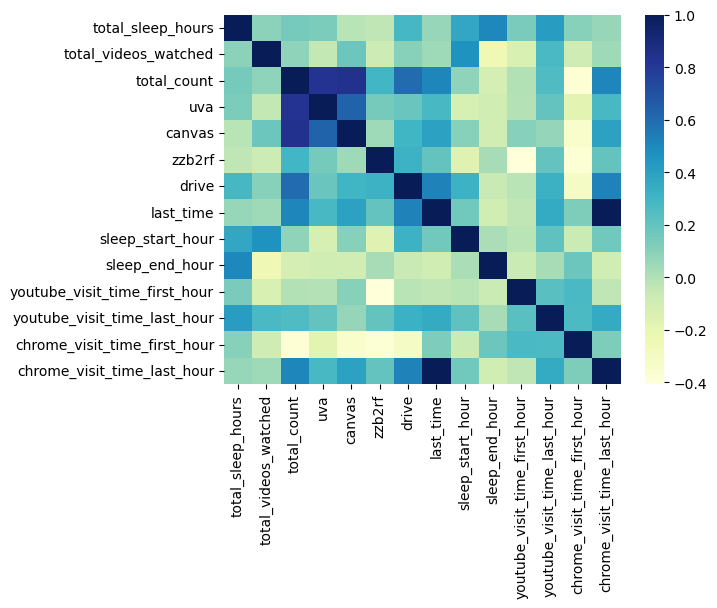

In [27]:
import sklearn
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

corr_matrix = df.corr(numeric_only=True)
corr_matrix.shape

corr_matrix["total_sleep_hours"].sort_values(ascending=False)

sns.heatmap(corr_matrix, cmap="YlGnBu")
plt.show()

In [28]:
df1 = df[df.isna().any(axis=1)]
len(df1)
df1.head()

,total_sleep_hours,total_videos_watched,total_count,uva,canvas,zzb2rf,drive,last_time,day_of_week,sleep_start_hour,sleep_end_hour,youtube_visit_time_first_hour,youtube_visit_time_last_hour,chrome_visit_time_first_hour,chrome_visit_time_last_hour
8,7.400,NaN,19,2,17,0,0,22.283333,Saturday,1.516667,9.033333,NaN,NaN,17.733333,22.283333
27,6.725,NaN,52,5,9,9,29,22.883333,Sunday,0.866667,9.000000,NaN,NaN,11.616667,22.883333
31,7.650,NaN,4,2,2,0,0,12.266667,Thursday,0.850000,8.666667,NaN,NaN,10.950000,12.266667


In [32]:
df["total_sleep_hours"].fillna(df["total_sleep_hours"].median(), inplace=True)

In [29]:
df_x = df.drop("total_sleep_hours", axis=1)
df_y = df["total_sleep_hours"].copy()

from sklearn.model_selection import train_test_split
x_train, xtest, y_train, ytest = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

housing_prep = x_train
housing_labels = y_train
test_labels = ytest
housing_num = housing_prep.select_dtypes(include=np.number)
housing_cat = housing_prep.select_dtypes(include="object")

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_attribs = housing_num.columns.tolist()
cat_attribs = housing_cat.columns.tolist()

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

housing_tr = full_pipeline.fit_transform(housing_prep)
housing_test = full_pipeline.transform(xtest)

In [10]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

lin_reg = LinearRegression()
lin_reg.fit(housing_tr, housing_labels)

housing_predictions = lin_reg.predict(housing_tr)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_mae = mean_absolute_error(housing_labels, housing_predictions)

print(f"RMSE: {lin_rmse}, MAE: {lin_mae}")

RMSE: 0.42064187661904356, MAE: 0.3215465790802205


In [32]:
lin_scores = cross_val_score(lin_reg, housing_tr, housing_labels,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 1.29989413 17.19185362  1.36937408  2.07548069  1.41747911]
Mean: 4.670816324790687
Standard deviation: 6.26672134970221


In [33]:
feature_names = list(full_pipeline.get_feature_names_out())

coefficients = lin_reg.coef_

# Create a DataFrame to store feature importance
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# Sort by absolute value to see the most impactful features
feature_importance["Absolute Coefficient"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values(by="Absolute Coefficient", ascending=False)

# Display the top features
print(feature_importance)

                               Feature  Coefficient  Absolute Coefficient
15           cat__day_of_week_Saturday     0.503742              0.503742
14             cat__day_of_week_Monday    -0.492722              0.492722
4                          num__zzb2rf    -0.405663              0.405663
3                          num__canvas    -0.348714              0.348714
5                           num__drive     0.345450              0.345450
17           cat__day_of_week_Thursday    -0.312953              0.312953
11   num__chrome_visit_time_first_hour    -0.292434              0.292434
8                  num__sleep_end_hour     0.285423              0.285423
9   num__youtube_visit_time_first_hour     0.264206              0.264206
19          cat__day_of_week_Wednesday     0.178293              0.178293
0            num__total_videos_watched     0.157386              0.157386
10   num__youtube_visit_time_last_hour     0.138757              0.138757
16             cat__day_of_week_Sunday

In [34]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_tr, housing_labels)

housing_predictions = tree_reg.predict(housing_tr)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_mae = mean_absolute_error(housing_labels, housing_predictions)

print(f"RMSE: {tree_rmse}, MAE: {tree_mae}")

RMSE: 0.0, MAE: 0.0


In [35]:
scores = cross_val_score(tree_reg, housing_tr, housing_labels,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [1.55298026 1.66585397 0.9437477  1.37271527 1.25631737]
Mean: 1.3583229142718767
Standard deviation: 0.250978768116825


In [36]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_tr, housing_labels)

housing_predictions = forest_reg.predict(housing_tr)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

forest_mae = mean_absolute_error(housing_labels, housing_predictions)

print(f"RMSE: {forest_rmse}, MAE: {forest_mae}")

RMSE: 0.3424953394422803, MAE: 0.27309523809523784


In [37]:
forest_scores = cross_val_score(forest_reg, housing_tr, housing_labels,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.98782244 1.22122111 0.4333614  0.83713812 0.94319734]
Mean: 0.8845480809228439
Standard deviation: 0.25817481729579006


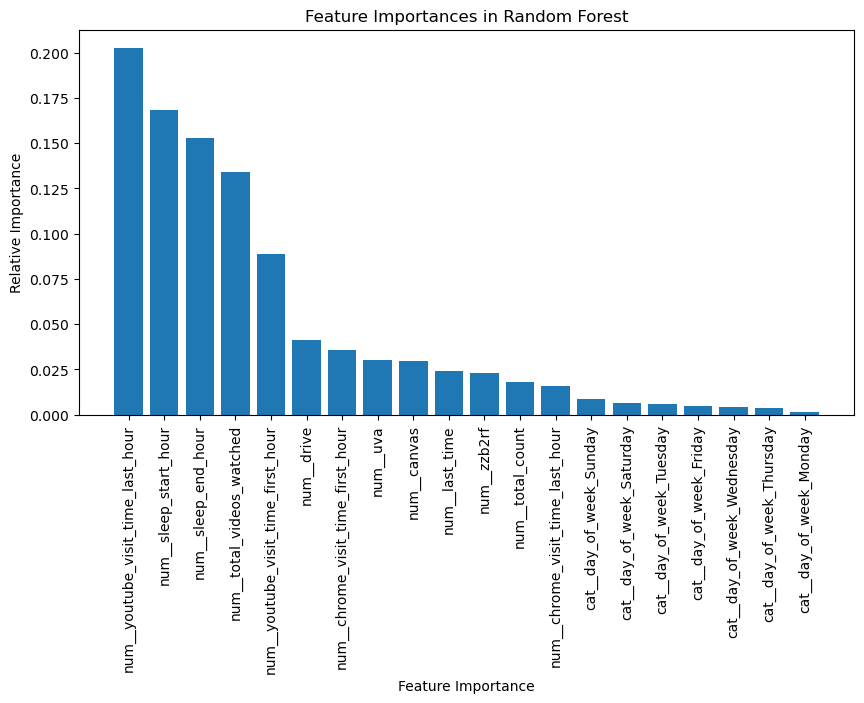

num__youtube_visit_time_last_hour: 0.2026
num__sleep_start_hour: 0.1684
num__sleep_end_hour: 0.1529
num__total_videos_watched: 0.1339
num__youtube_visit_time_first_hour: 0.0890
num__drive: 0.0415
num__chrome_visit_time_first_hour: 0.0357
num__uva: 0.0303
num__canvas: 0.0295
num__last_time: 0.0243
num__zzb2rf: 0.0229
num__total_count: 0.0178
num__chrome_visit_time_last_hour: 0.0158
cat__day_of_week_Sunday: 0.0088
cat__day_of_week_Saturday: 0.0066
cat__day_of_week_Tuesday: 0.0061
cat__day_of_week_Friday: 0.0050
cat__day_of_week_Wednesday: 0.0040
cat__day_of_week_Thursday: 0.0035
cat__day_of_week_Monday: 0.0013


In [39]:
forest_importances = forest_reg.feature_importances_
sorted_idx = np.argsort(forest_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(forest_importances)), forest_importances[sorted_idx], align="center")
plt.xticks(range(len(forest_importances)), np.array(feature_names)[sorted_idx], rotation=90)
plt.xlabel("Feature Importance")
plt.ylabel("Relative Importance")
plt.title("Feature Importances in Random Forest")
plt.show()

for feature, importance in sorted(zip(feature_names, forest_importances), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")